# Analyze der extract Daten

In [17]:
import pandas as pd

extract = '../01_data/chatbot_extract-1.csv'
names=['ticket', 'customer', 'complaint', 'state', 'answer']

corpus = pd.read_csv(extract, encoding='utf-8', names=names, skiprows=[0], usecols=[1, 2, 4, 5, 6])

# fix None value
corpus.complaint[67] = ''
corpus.head()

,ticket,customer,complaint,state,answer
0,Fehler in der App,Swissmem,"Normenauszug 2018, Rechenbuch Metall, Tabellenbuchs Metall, Fechkundebuch Metall, MachineWorld, Topdesign, Automation Control, Konstrukteur 1, Konstrukteur 2 und Konstrukteur 3 funktionieren nicht...",closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
1,Fehler in der App,SVBA,Ich kann die Bilder nicht mehr öffnen um mit dem Editorprogramm diese zu bearbeiten.,closed successful,"Coupon einlösen, Produkte nicht vorhanden"
2,Fehler in der App,hep,"Leider fehlen mir paar Kapitel im Lehrmittel (LM-A, D). Eins davon brauche ich jetzt in der Schule (Heizungs- und Lüftungsanlagen)Ich habe die App mehrfach gelöscht und neu installiert, funktionie...",closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
3,Anmeldung / Aktivierung,AGVS,"Ich kann im FK z.b. die Seite 605 nicht lesen weil da steht, Alle Seiten des Auszugs sind genutzt.",closed successful,Linux
4,Anmeldung / Aktivierung,SVBA,Ich kann das Kapitel Technisches Englisch nicht herunterladen es Steht immer unvollständige Installation,closed successful,"Coupon einlösen, Produkte nicht vorhanden"


### Verteilung
Die extract Daten sind nicht ausgewogen verteilt.

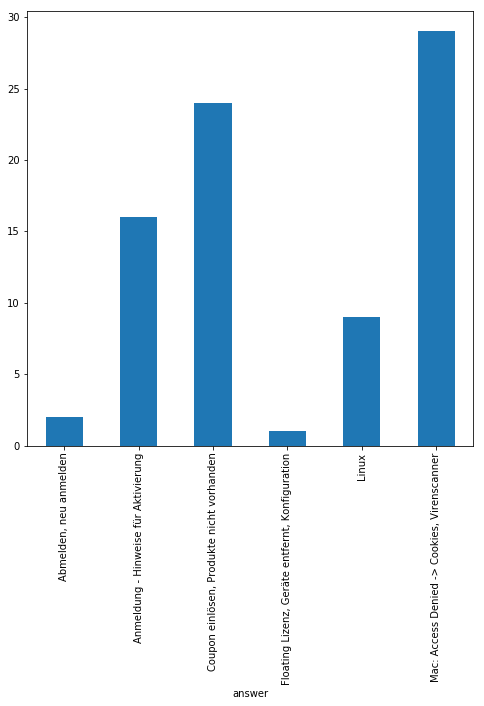

In [18]:
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
corpus.groupby('answer').complaint.count().plot.bar(ylim=0)
plt.show()

### Text pre-processing
Ab Zeile 60 gibt es irgendwo ein Problem mit dem Datentyp. Später anschauen.

In [19]:
import re
import nltk
import numpy as np

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('german')

def normalize_document(doc):
    # lower case and remove special characters \ whitespaces
    doc = re.sub(r'[^\u00C0-\u017Fa-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [21]:
corpus.complaint = normalize_corpus(list(corpus.complaint.array))
corpus.head()

,ticket,customer,complaint,state,answer
0,Fehler in der App,Swissmem,normenauszug rechenbuch metall tabellenbuchs metall fechkundebuch metall machineworld topdesign automation control konstrukteur konstrukteur konstrukteur funktionieren mehr kommt meldung mehr seit...,closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
1,Fehler in der App,SVBA,bilder mehr öffnen editorprogramm bearbeiten,closed successful,"Coupon einlösen, Produkte nicht vorhanden"
2,Fehler in der App,hep,leider fehlen paar kapitel lehrmittel lma d eins davon brauche schule heizungs lüftungsanlagenich app mehrfach gelöscht neu installiert funktioniert trotzdem computer schon heruntergefahren bitte ...,closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
3,Anmeldung / Aktivierung,AGVS,fk zb seite lesen steht seiten auszugs genutzt,closed successful,Linux
4,Anmeldung / Aktivierung,SVBA,kapitel technisches englisch herunterladen steht immer unvollständige installation,closed successful,"Coupon einlösen, Produkte nicht vorhanden"


### Text repräsentation
Hier ist zu sehen wi 81 Support Anfragen durch 26 features repräsentiert werden. Schöner wäre -> 81 Support Anfragen durch 240 features zu repräsentieren.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words=['zb']
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(corpus.complaint).toarray()
labels = corpus.answer
features.shape

(81, 26)

In [37]:
corpus['answer_id'] = corpus['answer'].factorize()[0]
answer_id_df = corpus[['answer', 'answer_id']].drop_duplicates().sort_values('answer_id')
answer_to_id = dict(answer_id_df.values)
id_to_answer = dict(answer_id_df[['answer_id', 'answer']].values)

answer_id_df

,answer,answer_id
0,"Mac: Access Denied -> Cookies, Virenscanner",0
1,"Coupon einlösen, Produkte nicht vorhanden",1
3,Linux,2
28,Anmeldung - Hinweise für Aktivierung,3
40,"Abmelden, neu anmelden",4
64,"Floating Lizenz, Geräte entfernt, Konfiguration",5


### naive bayes

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(corpus['complaint'], corpus['answer'], random_state = 0)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [45]:
print(clf.predict(count_vect.transform(
    ['''
        Ich kann die Dateien nicht mehr öffnen um mit dem Editorprogramm diese zu bearbeiten.
    ''']
)))

['Coupon einlösen, Produkte nicht vorhanden']


In [46]:
print(clf.predict(count_vect.transform(
    ['''
        Ich kann im FK z.b. die Seite 605 nicht lesen weil da steht, Alle Seiten des Auszugs sind genutzt.
    ''']
)))

['Coupon einlösen, Produkte nicht vorhanden']


### Model evaluation

c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages

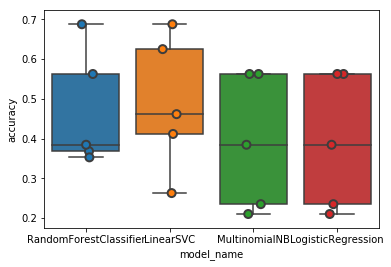

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [55]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.489792
LogisticRegression        0.391087
MultinomialNB             0.391087
RandomForestClassifier    0.471196
Name: accuracy, dtype: float64

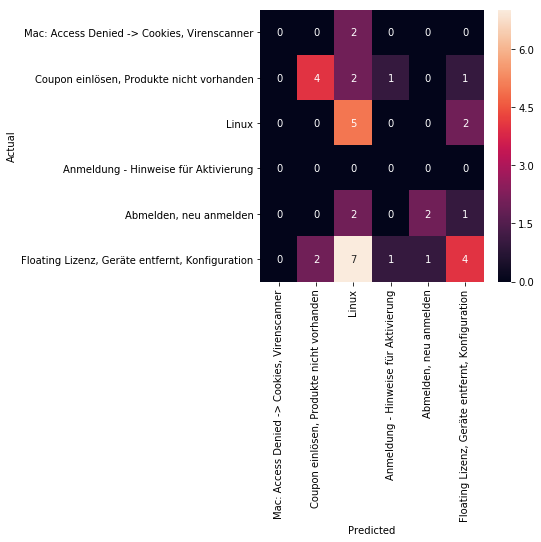

In [61]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [66]:
from IPython.display import display

for predicted in answer_id_df.answer_id:
    for actual in answer_id_df.answer_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.\n".format(id_to_answer[actual], id_to_answer[predicted], conf_mat[actual, predicted]))

'Floating Lizenz, Geräte entfernt, Konfiguration' predicted as 'Coupon einlösen, Produkte nicht vorhanden' : 2 examples.

'Mac: Access Denied -> Cookies, Virenscanner' predicted as 'Linux' : 2 examples.

'Coupon einlösen, Produkte nicht vorhanden' predicted as 'Linux' : 2 examples.

'Abmelden, neu anmelden' predicted as 'Linux' : 2 examples.

'Floating Lizenz, Geräte entfernt, Konfiguration' predicted as 'Linux' : 7 examples.

'Coupon einlösen, Produkte nicht vorhanden' predicted as 'Anmeldung - Hinweise für Aktivierung' : 1 examples.

'Floating Lizenz, Geräte entfernt, Konfiguration' predicted as 'Anmeldung - Hinweise für Aktivierung' : 1 examples.

'Floating Lizenz, Geräte entfernt, Konfiguration' predicted as 'Abmelden, neu anmelden' : 1 examples.

'Coupon einlösen, Produkte nicht vorhanden' predicted as 'Floating Lizenz, Geräte entfernt, Konfiguration' : 1 examples.

'Linux' predicted as 'Floating Lizenz, Geräte entfernt, Konfiguration' : 2 examples.

'Abmelden, neu anmelden' predi

In [67]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=corpus['answer'].unique()))

                                                 precision    recall  f1-score   support

    Mac: Access Denied -> Cookies, Virenscanner       0.00      0.00      0.00         2
      Coupon einlösen, Produkte nicht vorhanden       0.67      0.50      0.57         8
                                          Linux       0.28      0.71      0.40         7
           Anmeldung - Hinweise für Aktivierung       0.00      0.00      0.00         0
                         Abmelden, neu anmelden       0.67      0.40      0.50         5
Floating Lizenz, Geräte entfernt, Konfiguration       0.50      0.27      0.35        15

                                      micro avg       0.41      0.41      0.41        37
                                      macro avg       0.35      0.31      0.30        37
                                   weighted avg       0.49      0.41      0.41        37



c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\alkazua\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
